In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [6]:
batch_size = 1
image_size = (256, 256)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

## UNet with ASL

In [7]:
from Models import U_Net_ASL

U_NN_ASL = U_Net_ASL(input_shape, size_out=3, initial_lr=0.01, momentum=0.9, weight_decay=0, expansion_rate=1, device=device)

summary(U_NN_ASL, input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
U_Net_ASL                                     [1, 3, 256, 256]          --
├─ModuleDict: 1-1                             --                        --
│    └─Sequential: 2-1                        [1, 64, 256, 256]         --
│    │    └─CSC_block: 3-1                    [1, 64, 256, 256]         292
│    │    └─CSC_block: 3-2                    [1, 64, 256, 256]         8,576
│    └─MaxPool2d: 2-2                         [1, 64, 128, 128]         --
│    └─Sequential: 2-3                        [1, 128, 128, 128]        --
│    │    └─CSC_block: 3-3                    [1, 128, 128, 128]        16,896
│    │    └─CSC_block: 3-4                    [1, 128, 128, 128]        33,536
│    └─MaxPool2d: 2-4                         [1, 128, 64, 64]          --
│    └─Sequential: 2-5                        [1, 256, 64, 64]          --
│    │    └─CSC_block: 3-5                    [1, 256, 64, 64]          66,560
│   

In [ ]:
PATH = "./models/U_Net/U_NN_ASL.pth"

if exists(PATH):
    U_NN_ASL = torch.load(PATH)
    U_NN_ASL.eval()

In [8]:
criterion = CrossEntropyLoss()
epochs = 1

train_U_NET(U_NN_ASL, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=600, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   600] train_loss: 0.890
test_loss: 0.924, test_accuracy: 58.69743347167969
[1,  1200] train_loss: 0.859
test_loss: 1.011, test_accuracy: 55.26953887939453
[1,  1800] train_loss: 0.850
test_loss: 0.922, test_accuracy: 57.0352783203125
[1,  2400] train_loss: 0.821
test_loss: 0.856, test_accuracy: 62.20648956298828
[1,  3000] train_loss: 0.815
test_loss: 0.853, test_accuracy: 61.62773895263672
[1,  3600] train_loss: 0.808
test_loss: 0.851, test_accuracy: 60.17866516113281


In [9]:
torch.save(U_NN_ASL, "./models/U_Net/U_NN_ASL.pth")

In [8]:
U_NN_ASL = torch.load("./models/U_Net/U_NN_ASL.pth")

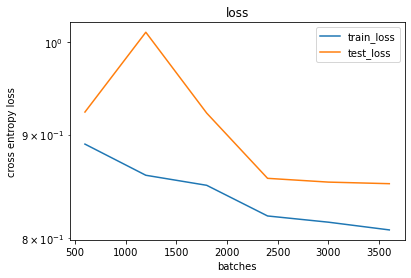

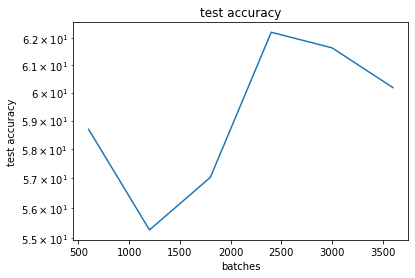

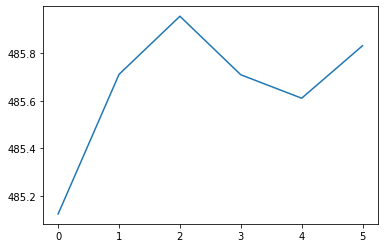

485.6579505713334


In [10]:
plot_loss(U_NN_ASL)
plot_acc(U_NN_ASL)

plt.plot(U_NN_ASL.train_time)
plt.show()
print(np.mean(U_NN_ASL.train_time))

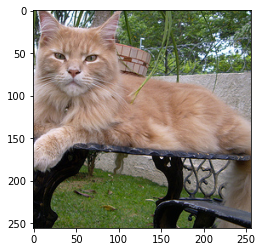

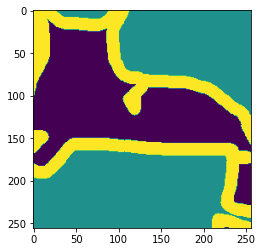

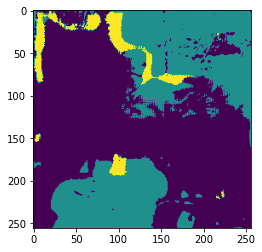

In [11]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

show_segmentation_results(U_NN_ASL, train_dataset, 1000, device)